Датасет описывает некоторую зависимость числа ***bugs*** от
значений ***repository_name***, ***commit_hash***, ***commit_date***,
***commit_author***, *commit_message*. Необходимо выявить
данную зависимость и написать скрипт/ноутбук, обучающий
модель по данному датасету

In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import seaborn as sns

In [211]:
! gdown --id 1I1p_QvYk3yDmKS18ou0F3Xze8k8aKZZs

Downloading...
From: https://drive.google.com/uc?id=1I1p_QvYk3yDmKS18ou0F3Xze8k8aKZZs
To: /content/bugs_dependence.csv
100% 30.3k/30.3k [00:00<00:00, 21.7MB/s]


In [212]:
df = pd.read_csv('/content/bugs_dependence.csv', parse_dates = ['commit_date'])

In [213]:
df.shape

(319, 6)

In [214]:
df.head()

,repository_name,commit_hash,commit_date,commit_author,commit_message,bugs
0,mlm,b28abb42,2020-06-12 14:26:12,Victor,объяснения предсказаний с помощью lime,4
1,mlm,438b5c4d,2020-06-12 11:53:10,Victor,Поставил lime вместо eli5,3
2,mlm,8e6e4f31,2020-06-11 15:19:03,Victor,Скрипт для создния пакетов обновления,4
3,mlm,5e0956a6,2020-06-11 10:42:29,Victor,Сортировка весов по убыванию,3
4,mlm,b9f4b40c,2020-06-11 09:25:19,Victor,не надо конвертировать массив до операции по с...,7


Посмотрим информацию о данных: есть ли незаполненные значения, в каком формате данные в столбцах




In [215]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   repository_name  319 non-null    object        
 1   commit_hash      319 non-null    object        
 2   commit_date      319 non-null    datetime64[ns]
 3   commit_author    319 non-null    object        
 4   commit_message   319 non-null    object        
 5   bugs             319 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 15.1+ KB


Пропусков в данных нет, все признаки типа object, целевая переменная типа int64

In [216]:
df.describe()

,bugs
count,319.000000
mean,2.996865
std,1.855636
min,0.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,12.000000


##Посмотрим распределение bugs

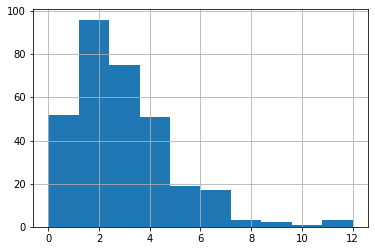

In [217]:
df['bugs'].hist();

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


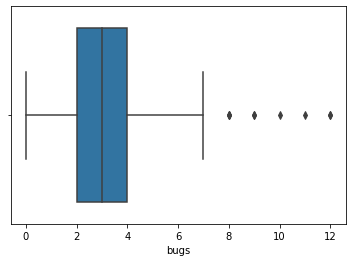

In [218]:
sns.boxplot(df['bugs']);

##Посмотрим распределение категориальных признаков

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


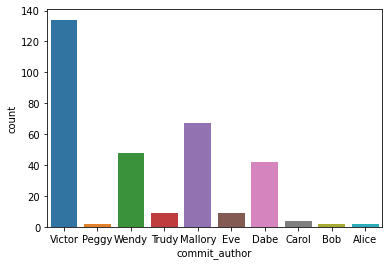

In [219]:
sns.countplot(df['commit_author']);

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


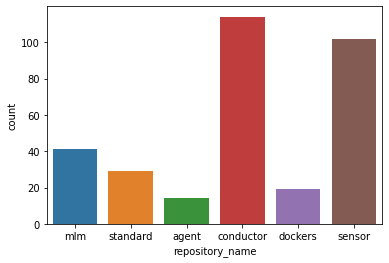

In [220]:
sns.countplot(df['repository_name']);

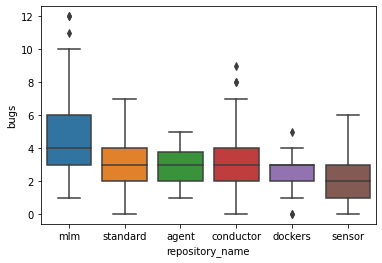

In [221]:
sns.boxplot(x='repository_name', y='bugs', data=df);

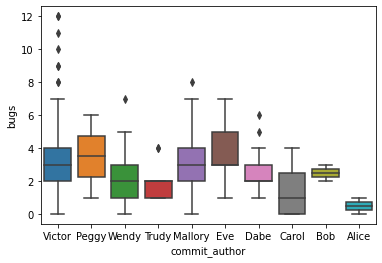

In [222]:
sns.boxplot(x='commit_author', y='bugs', data=df);

## Предобработка данных

Посмотрим кол-во уникальных признаков в столбцах 'commit_hash' и 'commit_mesage'

In [223]:
len(df['commit_hash'].unique())

319

In [224]:
len(df['commit_message'].unique())

309

In [225]:
df['commit_message'].value_counts().head(10)

Merge branch 'changes-to-merge' into 'master'    4
Initial commit                                   3
Update service.py                                2
Merge branch 'master' of                         2
moved config files to /opt/avssoft/configs       2
installer changes                                2
fix set_state                                    2
restore containers                               1
Fix proxy_install                                1
renamed filebeat compose config extension        1
Name: commit_message, dtype: int64

Все значения в 'commit_hash' уникальны. В 'commit_message' есть неуникальные значения, их немного и они неинформативны. Эти столбцы выступают в качестве идентификаторов. Их нужно будет убрать.

Отсортируем данные по дате

In [226]:
df = df.sort_values('commit_date')

Добавим столбцы: месяц, день, выходной/не выходной

In [227]:
df['month'] = df.commit_date.apply(lambda x : x.month)

In [228]:
df['day_of_week'] = df.commit_date.apply(lambda x : x.dayofweek)

In [229]:
df['is_weekend'] = df.commit_date.apply(lambda x : x.dayofweek//5 == 1).astype(int)

In [230]:
df

,repository_name,commit_hash,commit_date,commit_author,commit_message,bugs,month,day_of_week,is_weekend
40,mlm,79db41fb,2020-03-08 14:26:16,Victor,Initial commit,3,3,6,1
39,mlm,bfa1152f,2020-03-08 15:38:30,Victor,JsonMaster as function separator,6,3,6,1
38,mlm,29ba5151,2020-03-08 17:18:35,Victor,Small Fixes in models.py to make it work,12,3,6,1
37,mlm,a8b55539,2020-03-08 17:19:19,Victor,Added .gitignore,3,3,6,1
36,mlm,bb54e4e6,2020-03-08 17:23:12,Victor,Small Fixes in main.py to make it work,12,3,6,1
...,...,...,...,...,...,...,...,...,...
2,mlm,8e6e4f31,2020-06-11 15:19:03,Victor,Скрипт для создния пакетов обновления,4,6,3,0
85,conductor,ae539a47,2020-06-11 16:00:55,Wendy,add check before upload,2,6,3,0
84,conductor,ddf7c557,2020-06-12 09:45:18,Wendy,Улучшен алгоритм отправки файла,2,6,4,0
1,mlm,438b5c4d,2020-06-12 11:53:10,Victor,Поставил lime вместо eli5,3,6,4,0


##Посмотрим распределение новых категориальных данных (месяц, выходной/будний день, день недели)

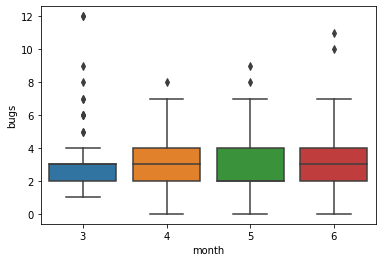

In [231]:
sns.boxplot(x='month', y='bugs', data=df)

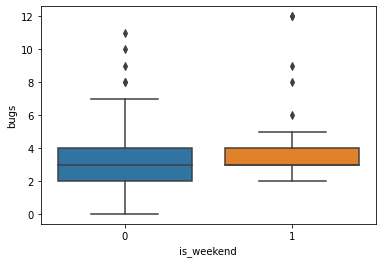

In [232]:
sns.boxplot(x='is_weekend', y='bugs', data=df)

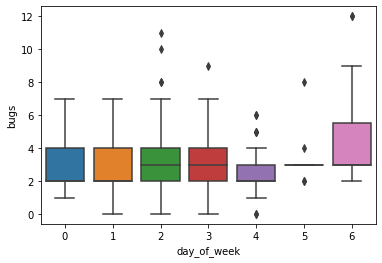

In [233]:
sns.boxplot(x='day_of_week', y='bugs', data=df)

#Разбивка данных

Уберем столбцы 'commit_date', 'commit_hash' и 'commit_message', т.к. все значения в них уникальны, получается, что они выступают в роли идентификаторов.

In [234]:
X_df, y_series = df.drop(['bugs', 'commit_date', 'commit_hash', 'commit_message' ], axis=1), df['bugs']

Преобразуем категориальные признаки

In [235]:
X_df = pd.get_dummies(X_df, columns=X_df.columns[:-1])

In [236]:
X_df

,is_weekend,repository_name_agent,repository_name_conductor,repository_name_dockers,repository_name_mlm,repository_name_sensor,repository_name_standard,commit_author_Alice,commit_author_Bob,commit_author_Carol,commit_author_Dabe,commit_author_Eve,commit_author_Mallory,commit_author_Peggy,commit_author_Trudy,commit_author_Victor,commit_author_Wendy,month_3,month_4,month_5,month_6,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
40,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1
39,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1
38,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1
37,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1
36,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0
85,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0
84,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0


Разделим данные на обучение и тест. Не будем использовать кросс-валидацию, т.к. данные отсортированы по времени.

In [237]:
train_share = 0.7

train_part_len = int(train_share * df.shape[0])

X_train = X_df.values[:train_part_len, :]
X_valid = X_df.values[train_part_len:, :]
y_train = y_series.values[:train_part_len]
y_valid = y_series.values[train_part_len:]

Проверим распределение 'bugs' на обучении и тесте

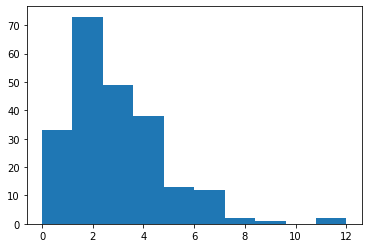

In [238]:
plt.hist(y_train);

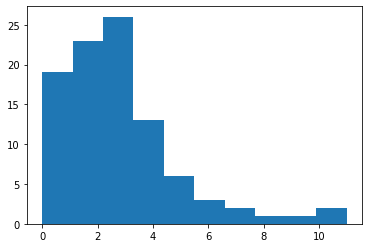

In [239]:
plt.hist(y_valid);

##Обучение моделей

Сравним несколько моделей: регрессию (методом наименьших квадратов), регрессию с L1 и L2 регуляризацией, случайный лес

In [274]:
linreg = LinearRegression()
lasso = Lasso(random_state=17)
ridge = Ridge(random_state=17)

lasso_cv = LassoCV(cv=2, random_state=17)
ridge_cv = RidgeCV(cv=2)

forest  = RandomForestRegressor(random_state=17)

In [275]:
def train_validate(model):
  model.fit(X_train, y_train)
  print("RMSE = " + str(np.sqrt(mean_squared_error(y_valid, model.predict(X_valid)))))

In [276]:
train_validate(linreg)

RMSE = 291272211211898.9


In [277]:
train_validate(lasso)

RMSE = 2.0133370690021564


In [278]:
train_validate(ridge)

RMSE = 2.0287838355496426


In [279]:
train_validate(lasso_cv)

RMSE = 1.9801354650599998


In [280]:
train_validate(ridge_cv)

RMSE = 1.8428005996506187


In [281]:
train_validate_report(forest)

MSE = 2.0298247437459787


#Лучшее значение RMSE получено для модели RidgeCV. Посмотрим коэффициенты перед признаками

In [273]:
pd.DataFrame(ridge_cv.coef_, X_df.columns, columns=['coef']).sort_values(by='coef', ascending=False)

,coef
repository_name_mlm,1.286973
commit_author_Eve,0.419877
commit_author_Mallory,0.362079
day_of_week_6,0.319630
commit_author_Victor,0.276867
is_weekend,0.269086
month_3,0.233547
day_of_week_2,0.204702
repository_name_standard,0.079820
day_of_week_3,0.065329
